In [10]:
# Install missing package required by this notebook
%pip install wordcloud matplotlib seaborn nltk gensim

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from collections import Counter 
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import warnings 
import re 
from wordcloud import WordCloud
import gensim.downloader as api
from gensim.models import TfidfModel
import gensim.corpora
from gensim.corpora import Dictionary
warnings.filterwarnings('ignore')

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to /Users/namdo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/namdo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/namdo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/namdo/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [4]:
df = pd.read_csv('reddit_hate_speech.csv')

print("Dataset shape: ", df.shape)
print("\nFirst few rows: ")
print(df.head())

print("\nColumn names: ")
print(df.columns)

print("\nData types: ")
print(df.dtypes)

print("\Class distribution: ")
print(df['class'].value_counts())


def clean_text(text):
    """Clean and normalize text"""
    text = str(text).lower()

    # Remove HTML entities
    text = re.sub(r'&amp;?', 'and', text)
    text = re.sub(r'&lt;', '<', text)
    text = re.sub(r'&gt;', '>', text)
    text = re.sub(r'&#\d+;', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove user mentions (@username)
    text = re.sub(r'@\w+', '', text)

    # Remove RT indicator
    text = re.sub(r'\brt\b', '', text)

    # Remove extra whilespace
    text = ' '.join(text.split())

    return text

def get_tokens(text):
    """
    Tokenize text into words
    """
    tokens = word_tokenize(text)
    # Keep only alphabetic tokens (remove punctuation, numbers, emoji)
    tokens = [token for token in tokens if token.isalpha() and len(token) > 1]

    return tokens

def count_pronouns(tokens):
    """
    Count pronouns in a list of tokens using POS tagging
    """
    if not tokens:
        return 0
    pos_tags = nltk.pos_tag(tokens)
    
    # Count personal pronouns (PRP) and possessive pronouns (PRP$)
    pronoun_count = sum([1 for word, tag in pos_tags if tag in ['PRP', 'PRP$']])

    return pronoun_count 



categories = ['hate_speech', 'offensive_language', 'neither']
stop_words = set(stopwords.words('english'))

class_labels = {
    0: 'hate_speech',
    1: 'offensive_language',
    2: 'neither'
}

# Add category name column 
df['category'] = df['class'].map(class_labels)
print(f"Category distribution: ")
print(df['category'].value_counts())

# Check if there is missing values
print(f"Missing values: ")
print(df.isnull().sum())

def get_top_frequent_words(n=30):
    top_30_words = {}
    print("\nExtracting top {n} frequent words per category...")

    for category in categories:
        # Get all tokens for this category (already computed earlier)
        # But we need to recompute with top 30
        category_df = df[df['category'] == category]
        
        all_tokens = []
        for tweet in category_df['tweet']:
            cleaned = clean_text(tweet)
            tokens = get_tokens(cleaned)
            all_tokens.extend(tokens)
        
        # Remove stopwords
        tokens_no_stop = [token for token in all_tokens if token not in stop_words]
        
        # Get top 30
        word_freq = Counter(tokens_no_stop)
        top_30 = word_freq.most_common(30)
        
        top_30_words[category] = {
            'words_list': [word for word, count in top_30],
            'words_set': set([word for word, count in top_30]),
            'words_freq': dict(top_30)
        }
        
        cat_display = category.replace('_', ' ').title()
        print(f"  ✓ {cat_display}: {len(top_30)} words extracted")
    return top_30_words

Dataset shape:  (24783, 7)

First few rows: 
   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  

Column names: 
Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

Data types: 
Unnamed: 0             int64
c

Processing: hate_speech
Number of tweets: 1430
Processing: offensive_language
Number of tweets: 19190
Processed 5000/19190 tweets
Processed 10000/19190 tweets
Processed 15000/19190 tweets
Processing: neither
Number of tweets: 4163

Task 1: Vocabulary and Statistcal Analysis
result category: dict_keys(['hate_speech', 'offensive_language', 'neither'])
result category: dict_keys(['hate_speech', 'offensive_language', 'neither'])
result category: dict_keys(['hate_speech', 'offensive_language', 'neither'])

          Category  Num Tweets  Vocabulary Size  Total Tokens  Avg Tokens/Post  Std Tokens/Post  Avg Pronouns/Post  Std Pronouns/Post
       Hate Speech        1430             3472         16566        11.584615         6.464387           1.083916           1.210655
Offensive Language       19190            15141        220967        11.514695         6.145947           1.098645           1.206770
           Neither        4163             9323         51418        12.351189         6.19

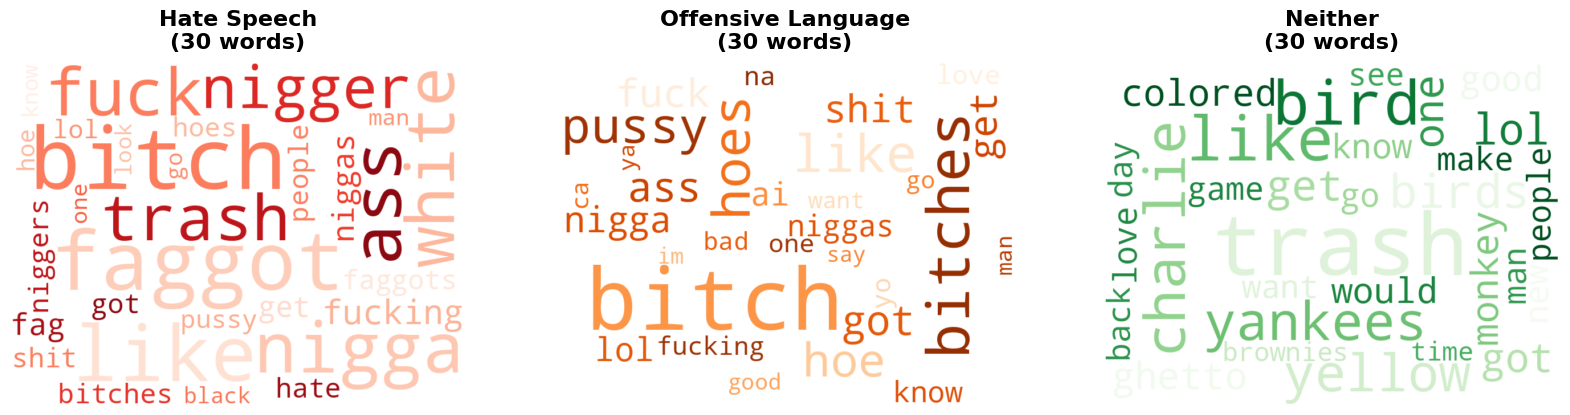

In [11]:
def task1_vocalubary_statistical_analysis():
    """Main function for Task 1"""
    results = {}
    for category in categories:
        print(f"Processing: {category}")

        # Filter tweets for this category
        category_df = df[df['category'] == category]
        print(f"Number of tweets: {len(category_df)}")
        all_tokens = []
        pronoun_counts = []
        token_counts = []
        for idx, tweet in enumerate(category_df['tweet']):
            # Clean the text
            cleaned = clean_text(tweet)

            # Tokenize 
            tokens = get_tokens(cleaned)

            # Store tokens
            all_tokens.extend(tokens)

            token_counts.append(len(tokens))

            pronoun_count = count_pronouns(tokens)
            pronoun_counts.append(pronoun_count)

            if (idx + 1) % 5000 == 0:
                print(f"Processed {idx + 1}/{len(category_df)} tweets")
            
        vocabulary = set(all_tokens)
        vocabulary_size = len(vocabulary)
        total_tokens = len(all_tokens)

        avg_tokens = np.mean(token_counts)
        std_tokens = np.std(token_counts)

        avg_pronouns = np.mean(pronoun_counts)
        std_pronouns = np.std(pronoun_counts)

        tokens_no_stop = [token for token in all_tokens if token not in stop_words]

        word_freq = Counter(tokens_no_stop)
        most_common_30 = word_freq.most_common(30)

        results[category] = {
            'vocabulary_size': vocabulary_size,
            'total_tokens': total_tokens,
            'avg_tokens_per_post': avg_tokens,
            'std_tokens_per_post': std_tokens,
            'avg_pronouns_per_post': avg_pronouns,
            'std_pronouns_per_post': std_pronouns,
            'top_30_words': most_common_30,
            'num_posts': len(category_df)
        }

    # Create summary table
    print("\n" + "="*80)
    print("Task 1: Vocabulary and Statistcal Analysis")
    print("="*80)
    
    summary_data = []
    for category in categories:
        print(f"result category: {results.keys()}")
        stats = results[category]
        summary_data.append({
            'Category': category.replace("_", " ").title(),
            'Num Tweets': stats['num_posts'],
            'Vocabulary Size': stats['vocabulary_size'],
            'Total Tokens': stats['total_tokens'],
            'Avg Tokens/Post': stats['avg_tokens_per_post'],
            'Std Tokens/Post': stats['std_tokens_per_post'],
            'Avg Pronouns/Post': stats['avg_pronouns_per_post'],
            'Std Pronouns/Post': stats['std_pronouns_per_post'] 
        })
    
    summary_df = pd.DataFrame(summary_data)

    print(f"\n" + summary_df.to_string(index=False))

    print("\n" + "="*80)
    print("Category Balance Analysis")
    print("="*80)

    category_counts = {}
    for category in categories: 
        category_counts[category] = results[category]['num_posts']
    
    total_tweets = sum(category_counts.values())

    print(f"\nTotal tweets in dataset: {total_tweets:,}")
    print("\nCategory distribution")
    print("-"*60)

    for category in categories:
        count = category_counts[category]
        percentage = (count / total_tweets) * 100
        cat_display = category.replace('_', ' ').title()

        # Visual bar
        bar_length = int(percentage / 2)
        bar = '█' * bar_length
        print(f"{cat_display:25s}: {count:6,} tweets ({percentage:5.2f}%) {bar}")


    counts = list(category_counts.values())
    max_count = max(counts)
    min_count = min(counts)
    imbalance_ratio = max_count / min_count

    print("\n" + "-" * 60)
    print(f"Balance Metrics: ")
    print(f"  Largest category: {max(category_counts, key=category_counts.get).replace('_', ' ').title()}")
    print(f"                     {max_count:,} tweets ({max_count/total_tweets*100:.1f}%)")
    print(f"  Smallest category: {min(category_counts, key=category_counts.get).replace('_', ' ').title()}")
    print(f"                     {min_count:,} tweets ({min_count/total_tweets*100:.1f}%)")
    print(f"  Imbalance ratio:   {imbalance_ratio:.2f}:1")

    # Calculate std
    count_std = np.std(counts)
    count_mean = np.mean(counts)
    count_cv = (count_std / count_mean) * 100

    print(f"\nStatistical Balance Metrics:")
    print(f"  Mean tweets/category:      {count_mean:.0f}")
    print(f"  Standard deviation:        {count_std:.0f}")
    print(f"  Coefficient of variation:  {count_cv:.2f}%")

    print(f"\n Balance Interpretation:")
    if imbalance_ratio < 1.5:
        print("  ✓ WELL-BALANCED dataset")
        print("    → All categories have similar sample sizes")
        print("    → No special handling needed for classification")
    elif imbalance_ratio < 3.0:
        print("  ️  MODERATELY IMBALANCED dataset")
        print("    → Some categories are underrepresented")
        print("    → Recommend: Use stratified splitting and class weights")
    elif imbalance_ratio < 10.0:
        print("  ️  HIGHLY IMBALANCED dataset")
        print("    → Significant class imbalance detected")
        print("    → Recommend: SMOTE, class weights, or balanced sampling")
    else:
        print("   SEVERELY IMBALANCED dataset")
        print("    → Extreme class imbalance")
        print("    → Critical: Advanced balancing techniques required")


    # Extract top 30 words for each category (excluding stopwords)
    top_30_words = get_top_frequent_words(30)
    print("\n" + "="*60)
    print("Top 30 Most Frequent Tokens for Each Category")
    print("="*60) 

    for cat in categories:
        cat_display = cat.replace("_", ' ').title()
        print(f"\n{cat_display}:")
        print("-"*60)


        words_list = top_30_words[category]['words_list']

        for i in range(0, 30, 3):
            row = []
            for j in range(3):
                if i + j < len(words_list):
                    word = words_list[i + j]
                    count = top_30_words[category]['words_freq'][word]
                    row.append(f"{i+j+1:2d}. {word:15s} ({count:5,})")
            print(" ".join(row))
    
    # Calculate overlap between all pairs of categories
    calculate_category_overlap(results, top_30_words)
    generate_wordcloud(results, top_30_words)

def calculate_category_overlap(categories_stats, top_30_words):
    overlap_matrix = {}
    for category in categories:
        overlap_matrix[category] = {}

    print("\nJaccard Similarity (Intersection / Union)")
    print("-"*70)
    for i, cat1 in enumerate(categories):
        for cat2 in categories[i+1:]:
            set1 = top_30_words[cat1]['words_set']
            set2 = top_30_words[cat2]['words_set']

            # Calculate overlap
            intersection = set1 & set2
            union = set1 | set2


            jaccard = len(intersection) / len(union) if len(union) > 0 else 0

            overlap_count = len(intersection)
            overlap_pct = (overlap_count / 30) * 100

            overlap_matrix[cat1][cat2] = overlap_count
            overlap_matrix[cat2][cat1] = overlap_count

            cat1_display = cat1.replace("_"," ").title()
            cat2_display = cat2.replace("_", " ").title()

            print(f"\n{cat1_display} ↔ {cat2_display}:")
            print(f"  Common words: {overlap_count}/30 ({overlap_pct:.1f}%)")
            print(f"  Jaccard similarity: {jaccard:.3f}")

            if intersection:
                common_sorted = sorted(intersection)
                print(f"  Shared words: {', '.join(common_sorted)}")
            else: 
                print("Shared common word: None")
    
    all_overlap = []
    for i, cat1 in enumerate(categories):
        for cat2 in categories[i+1:]:
            overlap_count = overlap_matrix[cat1][cat2]
            all_overlap.append(overlap_count)

    avg_overlap = np.mean(all_overlap)
    std_overlap = np.std(all_overlap)
    max_overlap = max(all_overlap)
    min_overlap = min(all_overlap)


    print("\n" + "="*70)
    print("Overall Overlap Statistics:")
    print(f"  Average overlap:        {avg_overlap:.1f} words ({avg_overlap/30*100:.1f}%)")
    print(f"  Standard deviation:     {std_overlap:.1f} words")
    print(f"  Maximum overlap:        {max_overlap} words ({max_overlap/30*100:.1f}%)")
    print(f"  Minimum overlap:        {min_overlap} words ({min_overlap/30*100:.1f}%)")


    print(f"\nOverlap Interpretation:")
    if avg_overlap < 5:
        print("  ✓ LOW overlap - Categories have DISTINCT vocabularies")
        print("    → Words are highly specific to each category")
        print("    → Excellent for vocabulary-based classification")
    elif avg_overlap < 10:
        print("    MODERATE overlap - Some shared vocabulary")
        print("    → Categories share some common words")
        print("    → Good separation but with some overlap")
    elif avg_overlap < 15:
        print("    HIGH overlap - Significant vocabulary sharing")
        print("    → Many words appear across categories")
        print("    → May need context-based features, not just word frequency")
    else:
        print("  VERY HIGH overlap - Categories use similar vocabulary")
        print("    → Extensive word sharing across categories")
        print("    → Word frequency alone may not distinguish categories well")



def generate_wordcloud(categories_stats, top_30_words):
    color_schemes = {
        'hate_speech': 'Reds',
        'offensive_language': 'Oranges',
        'neither': 'Greens'
    }

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    for idx, category in enumerate(categories):
        print(f"Generating wordcloud for category: {category.replace('_', ' ').title()}")
        word_freq = top_30_words[category]['words_freq'] 
        

        # Create word cloud
        wordcloud = WordCloud(
            width=800,
            height=600,
            background_color='white',
            colormap=color_schemes[category],
            relative_scaling=0.5,
            min_font_size=10,
            max_font_size=150,
            prefer_horizontal=0.7,
            collocations=False
        ).generate_from_frequencies(word_freq)
        # Plot
        ax = axes[idx]
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')

        cat_display = category.replace("_", " ").title()
        ax.set_title(f'{cat_display}\n({len(word_freq)} words)', fontsize=16, fontweight='bold', pad=10)

    plt.show()

task1_vocalubary_statistical_analysis()

In [14]:
def task2_tf_idf_category_relevant_tokens_analysis(top_30_words_by_freq):
    category_tokens = {}
    category_documents = {} # Treating each category as one document

    for cat in categories:
        print(f"Processing category: {cat.replace('_', ' ').title()}")

        category_df = df[df['category'] == cat]
        all_tokens = []
        for tweet in category_df['tweet']:
            cleaned = clean_text(tweet)
            tokens = get_tokens(cleaned)
            all_tokens.extend(tokens)
        
        tokens_no_stops = [token for token in all_tokens if token not in stopwords.words('english')]

        category_tokens[cat] = tokens_no_stops
        category_documents[cat] = tokens_no_stops

        print(f"Total tokens (no stop words): {len(all_tokens)}")
        print(f"Unique tokens: {len(set(all_tokens))}")
    

    # Build gensim dictionary and corpus
    print("\n" + "-"*80)
    print("Build Gensim Dictionary and Corpus")

    documents = [category_documents[cat] for cat in categories]

    # Use the Dictionary class imported from gensim.corpora to create the dictionary
    dictionary = Dictionary(documents)

    print(f"\nDictionary created: ")
    print(f"    Total unique tokens in all categories: {len(dictionary)}")
    print(f"    Token IDs range: 0 to {len(dictionary) - 1}")


    corpus = [dictionary.doc2bow(doc) for doc in documents]
    print(f"Corpus created")
    print(f"    Number of documents: {len(corpus)}")
    for idx, cat in enumerate(categories):
        print(f'    {cat.replace("_"," ").title()}: {len(corpus[idx])} unique tokens')

    print("\n" + "-"*80)
    print("Compute TF-IDF scores")
    print("-"*80)


    # Train TF-IDF model (pass corpus so idfs are computed)
    tfidf_model = TfidfModel(corpus)
    # Applies tf-idf transformation; this returns a TransformedCorpus wrapper
    corpus_tfidf = tfidf_model[corpus]

    print("\nTF-IDF trained succesfully")
    print("Computing tf-idf csores for each category")
    tfidf_score_by_category = {}
    for idx, category in enumerate(categories):
        print(f"what we have here: {corpus_tfidf}")
        tfidf_vector = corpus_tfidf[idx]

        # Convert to dictionary: {token_id: tfidf_score}
        tfidf_dict = dict(tfidf_vector)

        word_scores = {}
        for token_id, score in tfidf_dict.items():
            word = dictionary[token_id]
            word_scores[word] = score

        tfidf_score_by_category[category] = word_scores
        cat_display = category.replace("_", " ").title()
    print(f"    {cat_display}: {len(word_scores)} tokens scored")



    print("\n" + "-"*80)
    print("Extracting Top 30 Tokens by TF-IDF Score")

    tfidf_top30 = {}
    for category in categories:
        sorted_tokens = sorted(
            tfidf_score_by_category[category].items(),
            key=lambda x: x[1],
            reverse=True
        )

        top_30 = sorted_tokens[:30]

        tfidf_top30[category] = {
            'words_list': [word for word, score in top_30],
            'words_set': set([word for word, score in top_30]),
            'scores_dict': dict(top_30)
        }

        cat_display = category.replace("_", " ").title()
        print(f"\n{cat_display} - Top 30 by TF-IDF:")
        print("-"*60)


        for rank, (word, score) in enumerate(top_30, 1):
            print(f"    {rank:2d}. {word:20s} (TF-IDF: {score:.4f})")
    
    print("\n" + "="*80)
    print("Compare TF-IDF vs Frequency Rankings")
    print("="*80)


    overlap_analysis = {}
    for category in categories:
        freq_set = top_30_words_by_freq[category]['words_set']
        tfidf_set = tfidf_top30[category]['words_set']

        intersection = freq_set & tfidf_set
        only_in_freq = freq_set - tfidf_set
        only_in_tfidf = tfidf_set - freq_set

        overlap_count = len(intersection)
        overlap_pct = (overlap_count / 30) * 100


        overlap_analysis[category] = {
            'intersection': intersection,
            'only_in_frequency': only_in_freq,
            'only_in_tfidf': only_in_tfidf,
            'overlap_count': overlap_count,
            'overlap_percentage': overlap_pct
        }

        cat_display = category.replace("_", " ").title()

        print(f"\n{cat_display}")
        print("-"*70)
        print(f"    Overlap: {overlap_count}/30 words ({overlap_pct:.1f}%)")
        print(f"    Words in BOTH ranking: {overlap_count}")
        print(f"    Words ONLY in frequency ranking: {len(only_in_freq)}")
        print(f"    Words ONLY in TF-IDF ranking: {len(only_in_tfidf)}")

        if intersection:
            print(f"\n  Words in both ranking:")
            print(f"    {', '.join(sorted(intersection))}")
        
        if only_in_freq:
            print(f"\n  Words ONLY in frequency top-30 (not in TF-IDF top-30):")
            freq_only_list = sorted(only_in_freq)
            print(f"    {', '.join(freq_only_list)}")

        if only_in_tfidf:
            print(f"\n  Words ONLY in TF-IDF top-30 (not in frequency top-30):")
            tfidf_only_list = sorted(only_in_tfidf)
            print(f"    {', '.join(tfidf_only_list)}")


    # Calculate the avg and std for the overlap between top 30 frequent words and top 30 words with highest TF-IDF score
    print("\n" + "="*80)
    print("Overall comparison statistics")
    print("="*80)

    # Build a list of overlap counts for each category
    overlap_counts = [overlap_analysis[cat]['overlap_count'] for cat in categories]
    avg_overlap = np.mean(overlap_counts)
    std_overlap = np.std(overlap_counts)

    print(f"\nAverage overlap (TF-IDF vs Frequency): {avg_overlap:.1f}/30 words ({avg_overlap/30*100:.1f}%)")
    print(f"Standard deviation: {std_overlap:.1f} words")

    print("\nInterpretation: ")
    if avg_overlap > 20:
        print("  ✓ HIGH overlap (>20/30)")
        print("    → TF-IDF and frequency rankings are very similar")
        print("    → Most frequent words are also most distinctive")
        print("    → Both methods identify similar important words")
    elif avg_overlap > 15:
        print("    MODERATE overlap (15-20/30)")
        print("    → Some differences between TF-IDF and frequency")
        print("    → TF-IDF captures some distinctive words missed by frequency")
        print("    → Both methods complement each other")
    elif avg_overlap > 10:
        print("    LOW overlap (10-15/30)")
        print("    → Significant differences between TF-IDF and frequency")
        print("    → TF-IDF identifies many category-specific words")
        print("    → Frequency-based ranking includes many common words")
    else:
        print("    VERY LOW overlap (<10/30)")
        print("    → TF-IDF and frequency rankings are very different")
        print("    → Frequent words are often common across categories")
        print("    → TF-IDF better captures category-distinctive vocabulary")


top_30_words_by_freq = get_top_frequent_words(30)
task2_tf_idf_category_relevant_tokens_analysis(top_30_words_by_freq)




Extracting top {n} frequent words per category...
  ✓ Hate Speech: 30 words extracted
  ✓ Offensive Language: 30 words extracted
  ✓ Neither: 30 words extracted
Processing category: Hate Speech
Total tokens (no stop words): 16566
Unique tokens: 3472
Processing category: Offensive Language
Total tokens (no stop words): 220967
Unique tokens: 15141
Processing category: Neither
Total tokens (no stop words): 51418
Unique tokens: 9323

--------------------------------------------------------------------------------
Build Gensim Dictionary and Corpus

Dictionary created: 
    Total unique tokens in all categories: 19714
    Token IDs range: 0 to 19713
Corpus created
    Number of documents: 3
    Hate Speech: 3356 unique tokens
    Offensive Language: 15014 unique tokens
    Neither: 9201 unique tokens

--------------------------------------------------------------------------------
Compute TF-IDF scores
--------------------------------------------------------------------------------

TF-IDF